In [3]:
# Installing all required libraries
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn
!pip install --upgrade category_encoders
!pip install optuna
!pip install catboost

In [2]:
# Importing all required libraries
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler
from category_encoders import OneHotEncoder
from xgboost import DMatrix, cv, train
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
# 1. Load the Dataset

# Load the dataset
train_data = pd.read_csv('E:\\Studies\\IIT\\4 - Forth Year\\Applied AI\\Course Work\\Dataset  - Main - Allstate Claims Severity\\train.csv')

# Display basic info about the dataset
print("Train Data Info:")
print(train_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB
None


In [5]:
# 2. Feature Selection
# Select numeric columns for correlation
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate correlations with the target ('loss')
correlation_matrix = numeric_data.corr()
correlation_with_target = correlation_matrix['loss'].abs()

# Select features with high correlation to the target
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
selected_features.remove('loss')  # Exclude the target column

# Add categorical columns explicitly to the selection
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
selected_features += categorical_columns

print("Selected Features:")
print(selected_features)

Selected Features:
['cont2', 'cont3', 'cont7', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', '

In [6]:
# 3. Preprocessing the Data
# Separate features and target
X_train = train_data[selected_features]
y_train = train_data['loss']

# Identify categorical and numeric columns
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
numeric_columns = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]

# Encode categorical variables
encoder = OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])

# Apply PolynomialFeatures to numeric columns
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = pd.DataFrame(
    poly.fit_transform(X_train[numeric_columns]),
    columns=poly.get_feature_names_out(numeric_columns)
)

# Scale numeric features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly), columns=X_train_poly.columns)

# Combine processed features
X_train_processed = pd.concat([X_train_scaled, X_train_encoded.reset_index(drop=True)], axis=1)

print("Preprocessed Training Data Shape:", X_train_processed.shape)

c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Preprocessed Training Data Shape: (188318, 1148)


In [7]:
# 4. Outliers - Remove outliers in `loss` (target variable)
# Define outlier thresholds for 'loss' column
loss_threshold_lower = y_train.quantile(0.01)  # Lower 1% threshold
loss_threshold_upper = y_train.quantile(0.99)  # Upper 99% threshold

# Identify rows that are within the acceptable range
mask = (y_train >= loss_threshold_lower) & (y_train <= loss_threshold_upper)

# Filter out the outliers
X_train_outlier_removed = X_train_processed[mask]
y_train_outlier_removed = y_train[mask]

print(f"Original Data Shape: {X_train_processed.shape}, After Outlier Removal: {X_train_outlier_removed.shape}")

Original Data Shape: (188318, 1148), After Outlier Removal: (184550, 1148)


In [8]:
# 5. Feature engineering
# Generate polynomial features with reduced features and chunk processing
chunk_size = 10000
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

poly_features = []
for i in range(0, X_train_processed.shape[0], chunk_size):
    # Convert to NumPy array for slicing
    batch_data = X_train_processed.iloc[i : i + chunk_size].to_numpy()  # Ensure batch_data is a NumPy array
    batch_poly = poly.fit_transform(batch_data[:, :50])  # Limit to 50 features
    poly_features.append(batch_poly)

# Combine the processed chunks
X_train_poly = np.vstack(poly_features)

# Robust scaling to handle outliers
scaler = RobustScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

print(f"Enhanced Feature Shape: {X_train_poly_scaled.shape}")

Enhanced Feature Shape: (188318, 1275)


In [9]:
#6. Hyper parameter tuning
# Reduce dataset size for tuning
sample_fraction = 0.1  # Use 10% of the data
X_train_sampled = X_train_processed.sample(frac=sample_fraction, random_state=42)
y_train_sampled = y_train.sample(frac=sample_fraction, random_state=42)

# Select a subset of features for tuning
selected_features = X_train_sampled.columns[:50]  # Use only the first 50 features
X_train_sampled = X_train_sampled[selected_features]

# Convert sampled data to DMatrix with optimizations
dtrain_sampled = DMatrix(
    X_train_sampled,
    label=y_train_sampled,
    enable_categorical=False,  # Disable categorical support to save memory
    nthread=2                  # Use fewer threads
)

# Define the objective function for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 1.0, log=True),
    }
    # Perform cross-validation with fewer folds and rounds
    cv_results = cv(
        params=params,
        dtrain=dtrain_sampled,
        num_boost_round=50,       # Limit boosting rounds
        nfold=3,                  # Reduce folds
        metrics="rmse",
        early_stopping_rounds=10, # Early stopping
        verbose_eval=False,
    )
    # Return best RMSE
    return cv_results["test-rmse-mean"].min()

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Limit the number of trials

# Best parameters and score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

[I 2025-01-07 01:08:19,467] A new study created in memory with name: no-name-508174e3-e4c0-4f3e-8a33-cd67ee078205
[I 2025-01-07 01:08:20,005] Trial 0 finished with value: 2432.168087669725 and parameters: {'max_depth': 6, 'learning_rate': 0.07810359684925289, 'subsample': 0.653442894447871, 'colsample_bytree': 0.7797935742325995, 'reg_alpha': 0.16218335761418337, 'reg_lambda': 0.11006358245206621}. Best is trial 0 with value: 2432.168087669725.
[I 2025-01-07 01:08:20,322] Trial 1 finished with value: 2657.4582643611197 and parameters: {'max_depth': 3, 'learning_rate': 0.013259233501176014, 'subsample': 0.6042908464621749, 'colsample_bytree': 0.6327308275150222, 'reg_alpha': 0.21137007626685897, 'reg_lambda': 0.9161024367032458}. Best is trial 0 with value: 2432.168087669725.
[I 2025-01-07 01:08:20,671] Trial 2 finished with value: 2425.403714333767 and parameters: {'max_depth': 5, 'learning_rate': 0.04886505408963009, 'subsample': 0.7614718846175969, 'colsample_bytree': 0.6568160003280

Best Parameters: {'max_depth': 5, 'learning_rate': 0.07797484545381758, 'subsample': 0.6503707523244481, 'colsample_bytree': 0.6983093565620165, 'reg_alpha': 0.1842135977029572, 'reg_lambda': 0.4114015930241512}
Best RMSE: 2398.251957470453


In [10]:
# 7. Train Improved Ensemble (Simplified Version)

# Use X_train_processed instead of X_train_poly_scaled
X_train_simplified = X_train_processed.astype('float32')
y_train_simplified = y_train.astype('float32')

# Reduce training data size (sample a fraction of the data)
sample_fraction = 0.5  # Use 50% of the data
np.random.seed(42)
sample_indices = np.random.choice(
    np.arange(X_train_simplified.shape[0]),
    size=int(sample_fraction * X_train_simplified.shape[0]),
    replace=False
)
X_train_sampled = X_train_simplified.iloc[sample_indices]
y_train_sampled = y_train_simplified.iloc[sample_indices]

# Train individual models
# XGBoost
dtrain_sampled = DMatrix(X_train_sampled, label=y_train_sampled)
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
}
xgb_model = train(xgb_params, dtrain_sampled, num_boost_round=500)

# LightGBM
lgb_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    max_depth=10,
    n_estimators=200
)
lgb_model.fit(X_train_sampled, y_train_sampled)

# CatBoost
cat_model = CatBoostRegressor(
    learning_rate=0.05,
    depth=8,
    iterations=500,
    verbose=False
)
cat_model.fit(X_train_sampled, y_train_sampled)

print("Models trained successfully!")

c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 94159, number of used features: 767
[LightGBM] [Info] Start training from score 3035.330839
Models trained successfully!


In [11]:
# 8. Feature Importance for Ensemble Models
# Ensure the models (xgb_model, lgb_model, cat_model) are trained before running this code

# For XGBoost
feature_importances_xgb = xgb_model.get_score(importance_type='weight')
features_xgb = list(feature_importances_xgb.keys())
importance_values_xgb = list(feature_importances_xgb.values())

# For LightGBM
feature_importances_lgb = lgb_model.feature_importances_
features_lgb = X_train_sampled.columns.tolist()  # Assuming X_train_sampled is a DataFrame

# For CatBoost
feature_importances_cat = cat_model.get_feature_importance()
features_cat = X_train_sampled.columns.tolist()  # Assuming X_train_sampled is a DataFrame

# Combine feature importances by averaging (align on feature names)
all_features = list(set(features_xgb + features_lgb + features_cat))
combined_importance = {
    feature: (
        feature_importances_xgb.get(feature, 0) +  # XGBoost importance
        (feature_importances_lgb[features_lgb.index(feature)] if feature in features_lgb else 0) +  # LightGBM
        (feature_importances_cat[features_cat.index(feature)] if feature in features_cat else 0)  # CatBoost
    ) / 3
    for feature in all_features
}

# Convert combined importances to a DataFrame for easy viewing
important_features = pd.DataFrame({
    'Feature': list(combined_importance.keys()),
    'Importance': list(combined_importance.values())
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("Top 10 Important Features:")
print(important_features.head(10))

Top 10 Important Features:
          Feature  Importance
1088  cont2 cont7  621.423817
93          cont2  511.873251
119         cont7  443.779320
196   cont3 cont7  300.105561
936   cont2 cont3  226.554372
952         cont3  215.065620
905       cat79_D  156.122775
250       cat80_B  127.132912
929       cat81_D  119.021319
142       cat80_D  115.836843


In [12]:
# 9. Evaluate the Improved Ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Generate predictions for each model
xgb_predictions = xgb_model.predict(DMatrix(X_train_sampled))  # For XGBoost
lgb_predictions = lgb_model.predict(X_train_sampled)           # For LightGBM
cat_predictions = cat_model.predict(X_train_sampled)           # For CatBoost

# Combine predictions using weighted average (adjust weights as needed)
ensemble_weights = [0.33, 0.33, 0.34]  # Example weights
y_train_pred_ensemble = (
    ensemble_weights[0] * xgb_predictions +
    ensemble_weights[1] * lgb_predictions +
    ensemble_weights[2] * cat_predictions
)

ensemble_rmse = np.sqrt(mean_squared_error(y_train_sampled, y_train_pred_ensemble))
ensemble_mae = mean_absolute_error(y_train_sampled, y_train_pred_ensemble)
ensemble_r2 = r2_score(y_train_sampled, y_train_pred_ensemble)

print("Improved Ensemble Evaluation:")
print(f"RMSE: {ensemble_rmse}")
print(f"MAE: {ensemble_mae}")
print(f"R² Score: {ensemble_r2}")

# Calculate accuracy within ±10% of the actual values
percentage_error = np.abs((y_train_sampled - y_train_pred_ensemble) / y_train_sampled) * 100
accuracy_within_10 = (percentage_error <= 10).mean() * 100
print(f"Accuracy within ±10% of actual: {accuracy_within_10:.2f}%")

# Calculate accuracy within a fixed range (±500)
accuracy_within_500 = (np.abs(y_train_sampled - y_train_pred_ensemble) <= 500).mean() * 100
print(f"Accuracy within ±500 of actual: {accuracy_within_500:.2f}%")


Improved Ensemble Evaluation:
RMSE: 1696.3412068633527
MAE: 1134.9709392427349
R² Score: 0.6517384283308256
Accuracy within ±10% of actual: 15.78%
Accuracy within ±500 of actual: 34.01%


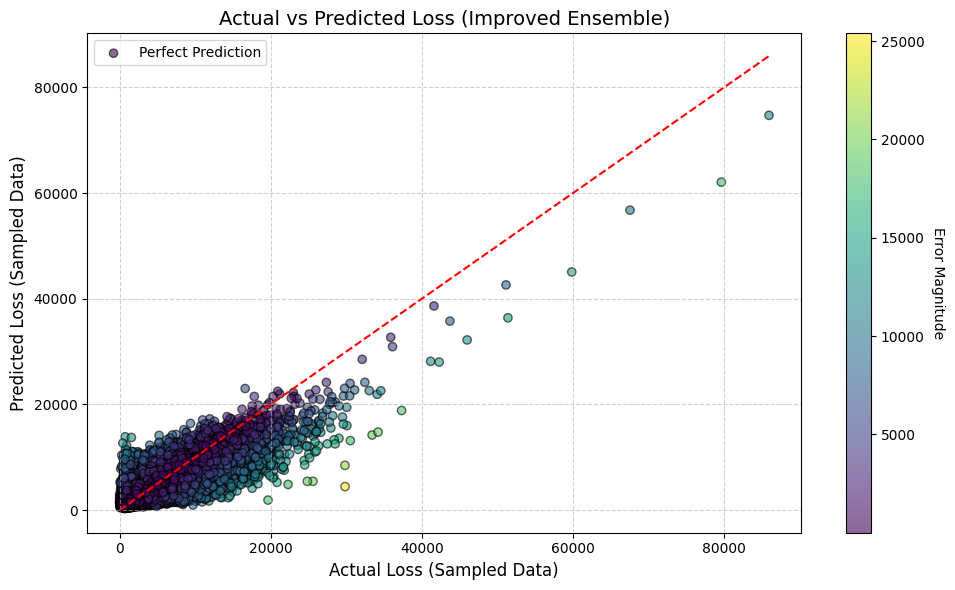

In [13]:
# 10. Scatterplot for the model
# Enhanced Scatterplot of Actual vs Predicted Loss

# Scatterplot with color indicating error magnitude
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    y_train_sampled,  # Use sampled actual labels
    y_train_pred_ensemble,  # Use ensemble predictions for the sampled data
    alpha=0.6,
    c=np.abs(y_train_sampled - y_train_pred_ensemble),  # Error magnitude as color
    cmap='viridis',
    edgecolor='k'
)

# Add a colorbar to indicate error magnitude
cbar = plt.colorbar(scatter)
cbar.set_label('Error Magnitude', rotation=270, labelpad=15)

# Add labels, title, and grid
plt.xlabel("Actual Loss (Sampled Data)", fontsize=12)
plt.ylabel("Predicted Loss (Sampled Data)", fontsize=12)
plt.title("Actual vs Predicted Loss (Improved Ensemble)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Add diagonal reference line for perfect predictions
min_loss = min(min(y_train_sampled), min(y_train_pred_ensemble))
max_loss = max(max(y_train_sampled), max(y_train_pred_ensemble))
plt.plot([min_loss, max_loss], [min_loss, max_loss], color='red', linestyle='--', label='Perfect Prediction')

# Add legend and adjust layout
plt.legend(["Perfect Prediction"])
plt.tight_layout()

# Show the plot
plt.show()



In [14]:
# 11. Save Results of actual and predicted loss value into csv

# Ensure consistency with sampled data
if 'id' in train_data.columns:
    id_column = train_data.iloc[sample_indices]['id']  # Match IDs to sampled data
else:
    print("Warning: 'id' column not found. Using index as ID.")
    id_column = train_data.iloc[sample_indices].index  # Use index as ID for sampled data

# Create a DataFrame to store comparison results
comparison_df = pd.DataFrame({
    'ID': id_column,
    'Actual Loss': y_train_sampled,
    'Predicted Loss': y_train_pred_ensemble
})

# Save the DataFrame to a CSV file
comparison_csv_path = 'xgboost_loss_comparison_sampled.csv'
comparison_df.to_csv(comparison_csv_path, index=False)

print(f"Comparison results saved to: {comparison_csv_path}")


Comparison results saved to: xgboost_loss_comparison_sampled.csv


In [16]:
#12. Accuracy summary
# Define thresholds for accuracy
percentage_threshold = 10  # Accuracy within ±10% of actual loss
fixed_threshold = 500      # Accuracy within ±500 of actual loss

# Calculate percentage-based accuracy for sampled data
percentage_error = np.abs((y_train_sampled - y_train_pred_ensemble) / y_train_sampled) * 100
accuracy_within_percentage = (percentage_error <= percentage_threshold).mean() * 100

# Calculate fixed threshold-based accuracy for sampled data
accuracy_within_fixed = (np.abs(y_train_sampled - y_train_pred_ensemble) <= fixed_threshold).mean() * 100

# Print exact accuracy
print(f"Accuracy within ±{percentage_threshold}% of actual: {accuracy_within_percentage:.2f}%")
print(f"Accuracy within ±{fixed_threshold} of actual: {accuracy_within_fixed:.2f}%")


Accuracy within ±10% of actual: 15.78%
Accuracy within ±500 of actual: 34.01%
